In [1]:
import numpy as np
import random
import sklearn.linear_model as linear
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as selection
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics

import torch as th
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
databasePath = "../eICU/training/"
exportPath = "../eICU/training/"

In [3]:
finalFeatures = pd.read_csv(databasePath + '/finalFeatures.csv')
finalFeatures = finalFeatures.fillna(0) # fills nan from kurtosis and skew
finalFeatures

,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
0,1412030,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,68.0,120.0,...,-1.4140,0.6875,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
1,1412271,37.6965,38.1204,38.0819,0.1278,11.0000,-3.3166,38.1204,103.0,112.0,...,0.2131,1.4000,2.4331,2.4331,2.4331,0.0000,0.0000,0.0000,2.4331,1.0
2,1412290,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,57.0,75.0,...,0.1274,1.2345,4.4543,4.4543,4.4543,0.0000,0.0000,0.0000,4.4543,0.0
3,1412660,37.4000,38.0000,37.7832,0.1822,-0.3726,-0.6013,37.8000,84.0,109.0,...,-0.5963,1.6136,0.8306,3.7375,3.6347,0.4814,21.5211,-4.7383,3.7375,0.0
4,1412840,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,70.0,106.0,...,-0.0575,1.0584,0.6420,1.7976,1.5475,0.2748,2.0620,-1.6282,1.5956,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199338,33532516,32.2000,37.7000,35.3112,2.1057,-1.7574,-0.2178,36.6000,51.0,104.0,...,-0.0645,2.6469,0.0980,5.6373,1.0889,0.9895,3.4195,1.6831,0.8171,1.0
199339,33532517,32.2000,37.4000,34.5467,1.8862,-1.7703,0.2656,33.4000,51.0,104.0,...,0.1481,2.5493,0.0980,5.6373,0.9832,1.0570,3.9619,1.9491,0.6334,1.0
199340,33532518,32.2000,36.8000,34.1643,1.7398,-1.4068,0.6213,33.1000,60.0,104.0,...,0.0064,2.4888,0.0980,5.6373,1.0385,1.1231,2.9569,1.7434,0.6010,1.0
199341,33532540,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,72.0,83.0,...,-2.1039,2.2769,0.3576,19.0703,3.7475,2.6719,13.1009,3.2470,2.3838,0.0


#### Balancing Data by Random Under-Sampling

In [4]:
sepsis = finalFeatures[finalFeatures['diagnosis'] == 1]
notSepsis = finalFeatures[finalFeatures['diagnosis'] == 0]
print(f'Sepsis Size: {sepsis.shape[0]} Not Sepsis Size: {notSepsis.shape[0]}')

Sepsis Size: 77520 Not Sepsis Size: 121823


In [5]:
notSepsis = notSepsis.sample(n=sepsis.shape[0])
print(f'Sepsis Size: {sepsis.shape[0]} Not Sepsis Size: {notSepsis.shape[0]}')
notSepsis

Sepsis Size: 77520 Not Sepsis Size: 77520


,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
57531,9830420,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,58.0,131.0,...,0.2950,1.7843,0.0109,4.3716,2.0104,1.2950,-1.2977,0.2100,1.9098,0.0
66342,10845550,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,51.0,111.0,...,0.3024,0.7099,0.3484,4.3554,1.7511,1.4827,-1.3876,0.6333,0.8711,0.0
95865,16021500,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,72.0,92.0,...,0.0000,0.7100,0.7398,7.2133,4.4230,2.5332,-1.7421,-0.0635,4.4024,0.0
110453,18052170,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,77.0,96.0,...,0.0000,1.9800,10.7345,10.7345,10.7345,0.0000,0.0000,0.0000,10.7345,0.0
55145,9703070,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,0.0,110.0,...,0.0000,1.9800,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125050,23037220,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,53.0,137.0,...,-1.1558,1.8186,0.4132,3.3058,1.5010,0.5414,2.3752,1.7755,1.3262,0.0
167095,30555730,35.8000,36.6500,36.6069,0.1664,15.4442,-4.0329,36.6500,45.0,101.0,...,0.6203,0.8096,0.0824,12.8007,3.0913,3.2009,3.0089,1.9395,2.0276,0.0
103117,17258350,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,66.0,94.0,...,1.1106,1.6209,39.5131,39.5131,39.5131,0.0000,0.0000,0.0000,39.5131,0.0
117147,20322640,29.1670,38.3890,37.1700,0.9627,33.0124,-4.6184,37.3330,73.0,139.0,...,-0.1132,0.9349,2.9985,3.7481,3.7419,0.0579,111.9285,-10.3055,3.7481,0.0


In [6]:
finalFeaturesBalanced = pd.concat([notSepsis, sepsis])
finalFeaturesBalanced = finalFeaturesBalanced.sample(frac=1)  #shuffle data
finalFeaturesBalanced

,patientid,temperature_min,temperature_max,temperature_mean,temperature_std,temperature_kurtosis,temperature_skew,temperature_median,heartrate_min,heartrate_max,...,creatinine_skew,creatinine_median,urineoutputbyweight_min,urineoutputbyweight_max,urineoutputbyweight_mean,urineoutputbyweight_std,urineoutputbyweight_kurtosis,urineoutputbyweight_skew,urineoutputbyweight_median,diagnosis
154575,29159530,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,0.0,125.0,...,0.3385,0.5766,6.9586,6.9586,6.9586,0.0000,0.0000,0.0000,6.9586,0.0
68382,10998380,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,65.0,147.0,...,1.0503,0.6000,0.0000,10.2389,2.2700,2.1824,3.2588,1.9394,1.3678,0.0
138465,26971930,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,62.0,120.0,...,-0.8340,0.6271,0.9506,7.6046,2.3417,0.8868,2.7647,1.4234,2.2608,0.0
75786,11854340,36.6000,37.4000,36.9676,0.2442,-1.6088,0.5626,36.7780,61.0,94.0,...,0.6866,6.1409,0.0000,1.1148,0.2235,0.3414,0.4440,1.2700,0.0000,0.0
196217,33362912,37.6965,38.1204,38.1132,0.0550,56.4306,-7.5812,38.1204,90.0,107.0,...,2.8986,3.1316,2.0619,6.1856,3.6189,0.9522,0.3760,0.6992,3.6082,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144179,27760950,38.1204,38.1204,38.1204,0.0000,0.0000,0.0000,38.1204,82.0,122.0,...,0.3090,0.6626,3.9370,13.1234,10.2952,1.6525,0.5092,-0.3856,10.2435,0.0
169370,30661549,23.8000,38.5000,36.1369,3.8556,5.2221,-2.6523,37.3000,61.0,151.0,...,1.0015,0.3924,0.0000,17.5850,1.8563,2.5055,8.7018,2.8650,1.1723,1.0
171801,30811094,22.1000,40.0000,30.1961,7.9961,-1.9855,-0.0167,36.2867,74.0,129.0,...,-0.1399,3.3353,0.3219,6.0086,1.7931,1.0995,0.9538,1.1364,1.4691,1.0
143686,27687782,37.6965,38.1204,38.1186,0.0276,232.4829,-15.2805,38.1204,94.0,164.0,...,1.2772,9.2927,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0


In [7]:
print('finalFeaturesBalanced diagnosis count:')
finalFeaturesBalanced.diagnosis.value_counts()

finalFeaturesBalanced diagnosis count:


1.0    77520
0.0    77520
Name: diagnosis, dtype: int64

#### Cleaning data and Sorting to Input and Target Arrays

In [8]:
X= [] # input (attributes)
y = [] # output (targets)

X= finalFeaturesBalanced.iloc[:, 1:57].values
y = finalFeaturesBalanced.iloc[:, 57].values


#### Setting up Models for Neural Network

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.BCELoss()

    def forward(self, x):
        return None

    def loss(self, x, y):
        probs = self.forward(x)
        return self.loss_func(probs, y)

    def predict_proba(self, x, as_numpy=False):
        res = self.forward(x)
        if as_numpy:
            res = res.cpu().detach().numpy()
        return res

    def predict(self, x, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(x, as_numpy)
        return probs > threshold

    def fit(self, x_train, x_test, y_train, y_test, epochs=1000, lr=0.1, lam=0):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        train_loss_curve = []
        test_loss_curve = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            train_loss_val = self.loss(x_train, y_train) + self.regularize(lam)
            train_loss_curve.append(train_loss_val.data.item())
            train_loss_val.backward()
            optimizer.step()
            
            test_loss_val = self.loss(x_test, y_test) + self.regularize(lam)
            test_loss_curve.append(test_loss_val.data.item())
            
            if epoch % 500 == 0:
                print(f'Epoch {epoch}, Train Loss: {train_loss_val:.5f}, Test Loss: {test_loss_val:.5f}')
            
            
        return train_loss_curve, test_loss_curve

    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [10]:
class FeedForwardModel(Model):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(56, 113, bias=True)
        self.act1 = nn.PReLU()
        self.l2 = nn.Linear(113, 56, bias=True)
        self.act2 = nn.PReLU()
        self.l3 = nn.Linear(56, 1, bias=True)
        self.act3 = nn.Sigmoid()

    def get_intermediary(self, x):
        res = self.l1(x)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)

        return res

    def forward(self, X):
        res = self.get_intermediary(X)
        res = self.l3(res)
        res = self.act3(res)
        return res

#### Applying Classifiers and Neural Network Model

In [11]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
def random_guessing(inputs):
    prediction = []
    
    for values in inputs:
        prediction.append(random.randint(0, 1))
        
    return prediction

In [13]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)

f1_lr = []
f1_nn = []
f1_rf = []
f1_gnb = []
f1_rand = []

precision_lr = []
precision_nn = []
precision_rf = []
precision_gnb = []
precision_rand = []

accuracy_lr = []
accuracy_nn = []
accuracy_rf = []
accuracy_gnb = []
accuracy_rand = []

recall_lr = []
recall_nn = []
recall_rf = []
recall_gnb = []
recall_rand = []

ras_lr = []
ras_nn = []
ras_rf = []
ras_gnb = []
ras_rand = []

train_curve = []
test_curve = []

def random_guessing(inputs):
    prediction = []
    
    for values in inputs:
        prediction.append(random.randint(0, 1))
        
    return prediction

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    lr = linear.LogisticRegression(solver='lbfgs')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    probs = lr.predict_proba(X_test)[:,1]
    f1_lr.append(metrics.f1_score(y_test, predictions))
    precision_lr.append(metrics.precision_score(y_test, predictions))
    accuracy_lr.append(metrics.accuracy_score(y_test, predictions))
    recall_lr.append(metrics.recall_score(y_test, predictions))
    ras_lr.append(metrics.roc_auc_score(y_test, predictions))
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    probs = rf.predict_proba(X_test)[:,1]
    f1_rf.append(metrics.f1_score(y_test, predictions))
    precision_rf.append(metrics.precision_score(y_test, predictions))
    accuracy_rf.append(metrics.accuracy_score(y_test, predictions))
    recall_rf.append(metrics.recall_score(y_test, predictions))
    ras_rf.append(metrics.roc_auc_score(y_test, predictions))
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictions = gnb.predict(X_test)
    probs = gnb.predict_proba(X_test)[:,1]
    f1_gnb.append(metrics.f1_score(y_test, predictions))
    precision_gnb.append(metrics.precision_score(y_test, predictions))
    accuracy_gnb.append(metrics.accuracy_score(y_test, predictions))
    recall_gnb.append(metrics.recall_score(y_test, predictions))
    ras_gnb.append(metrics.roc_auc_score(y_test, predictions))
    
    predictions = random_guessing(X_test)
    f1_rand.append(metrics.f1_score(y_test, predictions))
    precision_rand.append(metrics.precision_score(y_test, predictions))
    accuracy_rand.append(metrics.accuracy_score(y_test, predictions))
    recall_rand.append(metrics.recall_score(y_test, predictions))
    ras_rand.append(metrics.roc_auc_score(y_test, predictions))
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    ffnn = FeedForwardModel()
    ffnn.to(device)

    train_loss, test_loss = ffnn.fit(X_train, X_test, y_train, y_test, epochs=4000, lr=0.0002, lam=0.0001)
    
    train_curve.append(train_loss)
    test_curve.append(test_loss)
    
    predictions = ffnn.predict(X_test, as_numpy=True)
    probs = ffnn.predict_proba(X_test, as_numpy=True)
    
    f1_nn.append(metrics.f1_score(y_test.cpu(), predictions))
    precision_nn.append(metrics.precision_score(y_test.cpu(), predictions))
    accuracy_nn.append(metrics.accuracy_score(y_test.cpu(), predictions))
    recall_nn.append(metrics.recall_score(y_test.cpu(), predictions))
    ras_nn.append(metrics.roc_auc_score(y_test.cpu(), predictions))

Epoch 0, Train Loss: 0.69422, Test Loss: 0.69200
Epoch 500, Train Loss: 0.35608, Test Loss: 0.35719
Epoch 1000, Train Loss: 0.24837, Test Loss: 0.24473
Epoch 1500, Train Loss: 0.19964, Test Loss: 0.19242
Epoch 2000, Train Loss: 0.17310, Test Loss: 0.16432
Epoch 2500, Train Loss: 0.15562, Test Loss: 0.14872
Epoch 3000, Train Loss: 0.14178, Test Loss: 0.13303
Epoch 3500, Train Loss: 0.12922, Test Loss: 0.12326
Epoch 0, Train Loss: 0.69467, Test Loss: 0.69340
Epoch 500, Train Loss: 0.35945, Test Loss: 0.35747
Epoch 1000, Train Loss: 0.25491, Test Loss: 0.25337
Epoch 1500, Train Loss: 0.20845, Test Loss: 0.20653
Epoch 2000, Train Loss: 0.18390, Test Loss: 0.18448
Epoch 2500, Train Loss: 0.16486, Test Loss: 0.16439
Epoch 3000, Train Loss: 0.15273, Test Loss: 0.15303
Epoch 3500, Train Loss: 0.14336, Test Loss: 0.14235
Epoch 0, Train Loss: 0.69606, Test Loss: 0.69452
Epoch 500, Train Loss: 0.34047, Test Loss: 0.33879
Epoch 1000, Train Loss: 0.23592, Test Loss: 0.23566
Epoch 1500, Train Loss: 

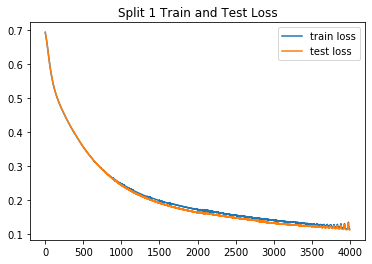

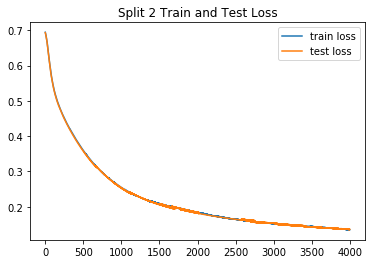

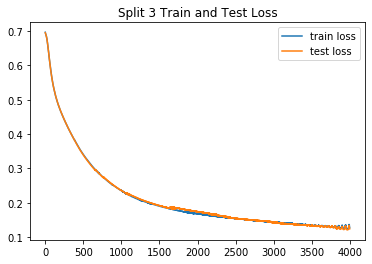

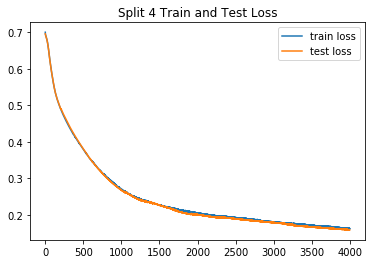

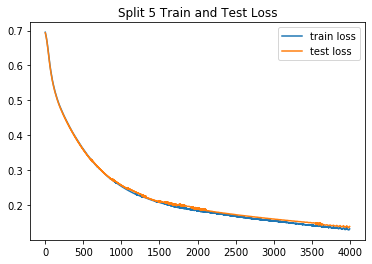

In [14]:
for i in range(len(train_curve)):
    plt.plot(train_curve[i], label='train loss')
    plt.plot(test_curve[i], label='test loss')
    plt.legend()
    plt.title(f'Split {str(i+1)} Train and Test Loss')
    plt.show()

In [15]:
def plot_loss(loss_curve, i):
    plt.plot(list(range(len(loss_curve))), loss_curve, label=f'Split {i+1}')

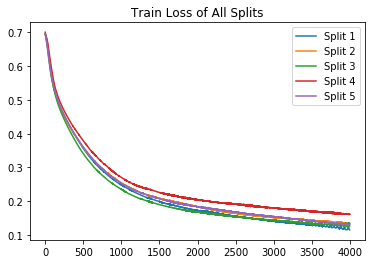

In [16]:
for i, curve in enumerate(train_curve):
    plot_loss(curve, i)

plt.legend()
plt.title('Train Loss of All Splits')
plt.show()

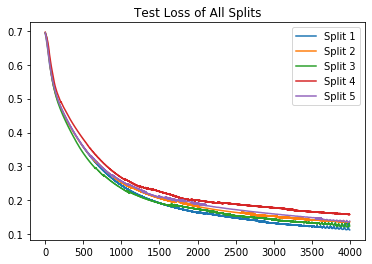

In [17]:
for i, curve in enumerate(test_curve):
    plot_loss(curve, i)

plt.legend()
plt.title('Test Loss of All Splits')
plt.show()

#### Comparing Statistical Results for the Models

In [18]:
print("Random Guessing Model F1 Score Mean: ", np.mean(f1_rand))
print("Random Guessing Model F1 Score Standard Deviation: ", np.std(f1_rand), '\n')

print("Random Guessing Model Precision Score Mean: ", np.mean(precision_rand))
print("Random Guessing Model Precision Score Standard Deviation: ", np.std(precision_rand), '\n')

print("Random Guessing Model Accuracy Score Mean: ", np.mean(accuracy_rand))
print("Random Guessing Model Accuracy Score Standard Deviation: ", np.std(accuracy_rand), '\n')

print("Random Guessing Model Recall Score Mean: ", np.mean(recall_rand))
print("Random Guessing Model Recall Score Standard Deviation: ", np.std(recall_rand), '\n')

print("Random Guessing Model ROC AUC Score Mean: ", np.mean(ras_rand))
print("Random Guessing Model ROC AUC Score Standard Deviation: ", np.std(ras_rand))

Random Guessing Model F1 Score Mean:  0.5012453744276023
Random Guessing Model F1 Score Standard Deviation:  0.00434604989286927 

Random Guessing Model Precision Score Mean:  0.5013471005708071
Random Guessing Model Precision Score Standard Deviation:  0.003801968089596135 

Random Guessing Model Accuracy Score Mean:  0.5013673890608875
Random Guessing Model Accuracy Score Standard Deviation:  0.002399658206053371 

Random Guessing Model Recall Score Mean:  0.5011490985954288
Random Guessing Model Recall Score Standard Deviation:  0.0051035406087843556 

Random Guessing Model ROC AUC Score Mean:  0.5013583071652559
Random Guessing Model ROC AUC Score Standard Deviation:  0.002400074833936533


In [19]:
print("Logistic Regression Model F1 Score Mean: ", np.mean(f1_lr))
print("Logistic Regression Model F1 Score Standard Deviation: ", np.std(f1_lr), '\n')

print("Logistic Regression Model Precision Score Mean: ", np.mean(precision_lr))
print("Logistic Regression Model Precision Score Standard Deviation: ", np.std(precision_lr), '\n')

print("Logistic Regression Model Accuracy Score Mean: ", np.mean(accuracy_lr))
print("Logistic Regression Model Accuracy Score Standard Deviation: ", np.std(accuracy_lr), '\n')

print("Logistic Regression Model Recall Score Mean: ", np.mean(recall_lr))
print("Logistic Regression Model Recall Score Standard Deviation: ", np.std(recall_lr), '\n')

print("Logistic Regression Model ROC AUC Score Mean: ", np.mean(ras_lr))
print("Logistic Regression Model ROC AUC Score Standard Deviation: ", np.std(ras_lr))

Logistic Regression Model F1 Score Mean:  0.9445529590346364
Logistic Regression Model F1 Score Standard Deviation:  0.0013035107308001792 

Logistic Regression Model Precision Score Mean:  0.9662126941095923
Logistic Regression Model Precision Score Standard Deviation:  0.0009802800165197535 

Logistic Regression Model Accuracy Score Mean:  0.9457752837977296
Logistic Regression Model Accuracy Score Standard Deviation:  0.0009935014455021427 

Logistic Regression Model Recall Score Mean:  0.9238436665272467
Logistic Regression Model Recall Score Standard Deviation:  0.0017109273286346424 

Logistic Regression Model ROC AUC Score Mean:  0.9457723479636897
Logistic Regression Model ROC AUC Score Standard Deviation:  0.0010975437097262236


In [20]:
print("Random Forest Model F1 Score Mean: ", np.mean(f1_rf))
print("Random Forest Model F1 Score Standard Deviation: ", np.std(f1_rf), '\n')

print("Random Forest Model Precision Score Mean: ", np.mean(precision_rf))
print("Random Forest Model Precision Score Standard Deviation: ", np.std(precision_rf), '\n')

print("Random Forest Model Accuracy Score Mean: ", np.mean(accuracy_rf))
print("Random Forest Model Accuracy Score Standard Deviation: ", np.std(accuracy_rf), '\n')

print("Random Forest Model Recall Score Mean: ", np.mean(recall_rf))
print("Random Forest Model Recall Score Standard Deviation: ", np.std(recall_rf), '\n')

print("Random Forest Model ROC AUC Score Mean: ", np.mean(ras_rf))
print("Random Forest Model ROC AUC Score Standard Deviation: ", np.std(ras_rf), '\n')

Random Forest Model F1 Score Mean:  0.9953818709973884
Random Forest Model F1 Score Standard Deviation:  0.0004925575138499222 

Random Forest Model Precision Score Mean:  0.9910598719810336
Random Forest Model Precision Score Standard Deviation:  0.0009715915400109203 

Random Forest Model Accuracy Score Mean:  0.9953624871001031
Random Forest Model Accuracy Score Standard Deviation:  0.00048670406294926415 

Random Forest Model Recall Score Mean:  0.9997422225216266
Random Forest Model Recall Score Standard Deviation:  0.00011505060683218 

Random Forest Model ROC AUC Score Mean:  0.995363591863588
Random Forest Model ROC AUC Score Standard Deviation:  0.00047768203260583497 



In [21]:
print("Gaussian Naive Bayes Model F1 Score Mean: ", np.mean(f1_gnb))
print("Gaussian Naive Bayes Model F1 Score Standard Deviation: ", np.std(f1_gnb), '\n')

print("Gaussian Naive Bayes Model Precision Score Mean: ", np.mean(precision_gnb))
print("Gaussian Naive Bayes Model Precision Score Standard Deviation: ", np.std(precision_gnb), '\n')

print("Gaussian Naive Bayes Model Accuracy Score Mean: ", np.mean(accuracy_gnb))
print("Gaussian Naive Bayes Model Accuracy Score Standard Deviation: ", np.std(accuracy_gnb), '\n')

print("Gaussian Naive Bayes Model Recall Score Mean: ", np.mean(recall_gnb))
print("Gaussian Naive Bayes Model Recall Score Standard Deviation: ", np.std(recall_gnb), '\n')

print("Gaussian Naive Bayes Model ROC AUC Score Mean: ", np.mean(ras_gnb))
print("Gaussian Naive Bayes Model ROC AUC Score Standard Deviation: ", np.std(ras_gnb), '\n')

Gaussian Naive Bayes Model F1 Score Mean:  0.8705096505569287
Gaussian Naive Bayes Model F1 Score Standard Deviation:  0.0074846720507725385 

Gaussian Naive Bayes Model Precision Score Mean:  0.9208736943001593
Gaussian Naive Bayes Model Precision Score Standard Deviation:  0.004458607979028456 

Gaussian Naive Bayes Model Accuracy Score Mean:  0.8772768317853459
Gaussian Naive Bayes Model Accuracy Score Standard Deviation:  0.005773536126011213 

Gaussian Naive Bayes Model Recall Score Mean:  0.8255965700234276
Gaussian Naive Bayes Model Recall Score Standard Deviation:  0.016228036752475434 

Gaussian Naive Bayes Model ROC AUC Score Mean:  0.8772875229406027
Gaussian Naive Bayes Model ROC AUC Score Standard Deviation:  0.005698171005655694 



In [22]:
print("Neural Network Model F1 Score Mean: ", np.mean(f1_nn))
print("Neural Network Model F1 Score Standard Deviation: ", np.std(f1_nn), '\n')

print("Neural Network Model Precision Score Mean: ", np.mean(precision_nn))
print("Neural Network Model Precision Score Standard Deviation: ", np.std(precision_nn), '\n')

print("Neural Network Model Accuracy Score Mean: ", np.mean(accuracy_nn))
print("Neural Network Model Accuracy Score Standard Deviation: ", np.std(accuracy_nn), '\n')

print("Neural Network Model Recall Score Mean: ", np.mean(recall_nn))
print("Neural Network Model Recall Score Standard Deviation: ", np.std(ras_nn), '\n')

print("Neural Network Model ROC AUC Score Mean: ", np.mean(ras_nn))
print("Neural Network Model ROC AUC Score Standard Deviation: ", np.std(ras_nn), '\n')

Neural Network Model F1 Score Mean:  0.9577537669757042
Neural Network Model F1 Score Standard Deviation:  0.003047122428573804 

Neural Network Model Precision Score Mean:  0.9630627531933751
Neural Network Model Precision Score Standard Deviation:  0.009584809481873636 

Neural Network Model Accuracy Score Mean:  0.9579914860681115
Neural Network Model Accuracy Score Standard Deviation:  0.002870813995943416 

Neural Network Model Recall Score Mean:  0.9526946155748114
Neural Network Model Recall Score Standard Deviation:  0.00288122149082246 

Neural Network Model ROC AUC Score Mean:  0.9580230934762209
Neural Network Model ROC AUC Score Standard Deviation:  0.00288122149082246 



In [23]:
resultdf = pd.DataFrame(columns=['Classifiers', 'F1 Score', 'Accuracy Score', 'Precision Score', 'Recall Score', 'ROC AUC Score'])

resultdf.loc[0] = 'Random Guessing', np.mean(f1_rand), np.mean(accuracy_rand), np.mean(precision_rand), np.mean(recall_rand),  np.mean(ras_rand)
resultdf.loc[1] = 'Logistic Regression', np.mean(f1_lr), np.mean(accuracy_lr), np.mean(precision_lr), np.mean(recall_lr),  np.mean(ras_lr)
resultdf.loc[2] = 'Neural Network', np.mean(f1_nn), np.mean(accuracy_nn), np.mean(precision_nn), np.mean(recall_nn),  np.mean(ras_nn)
resultdf.loc[3] = 'Random Forest', np.mean(f1_rf), np.mean(accuracy_rf), np.mean(precision_rf), np.mean(recall_rf),  np.mean(ras_rf)
resultdf.loc[4] = 'Gaussian Naive Bayes ', np.mean(f1_gnb), np.mean(accuracy_gnb), np.mean(precision_gnb), np.mean(recall_gnb),  np.mean(ras_gnb)

resultdf

,Classifiers,F1 Score,Accuracy Score,Precision Score,Recall Score,ROC AUC Score
0,Random Guessing,0.501245,0.501367,0.501347,0.501149,0.501358
1,Logistic Regression,0.944553,0.945775,0.966213,0.923844,0.945772
2,Neural Network,0.957754,0.957991,0.963063,0.952695,0.958023
3,Random Forest,0.995382,0.995362,0.991060,0.999742,0.995364
4,Gaussian Naive Bayes,0.870510,0.877277,0.920874,0.825597,0.877288


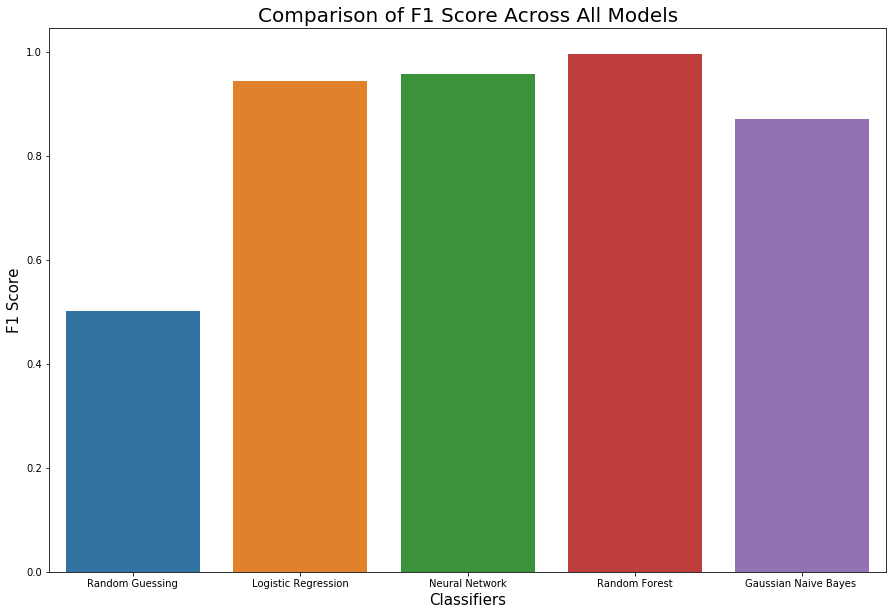

In [24]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='F1 Score')
plt.title('Comparison of F1 Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("F1 Score", fontsize=15)
plt.show()

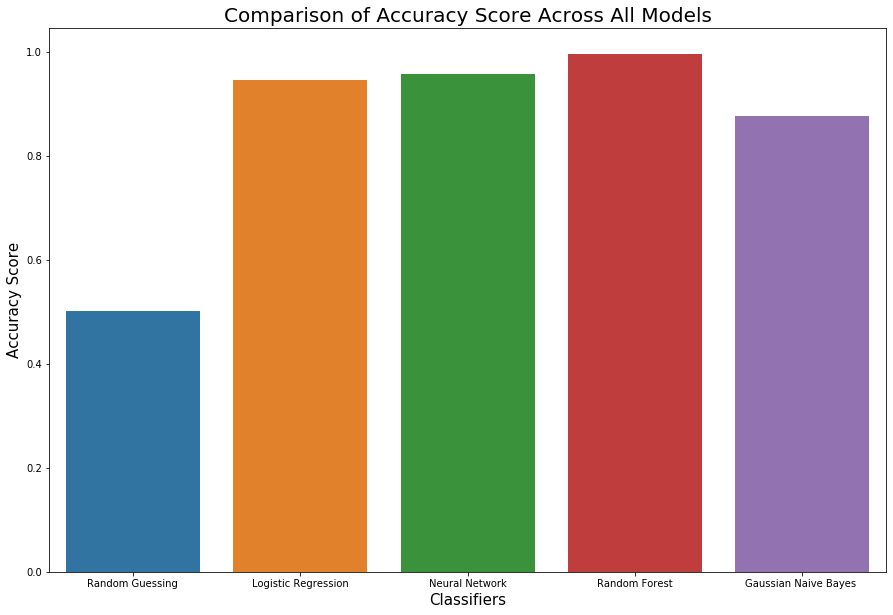

In [25]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Accuracy Score')
plt.title('Comparison of Accuracy Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.show()

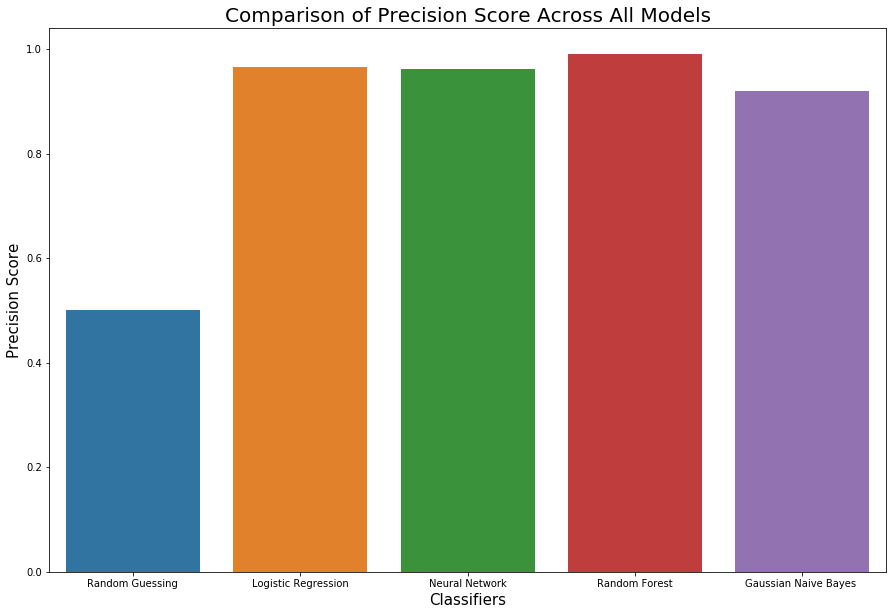

In [26]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Precision Score')
plt.title('Comparison of Precision Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Precision Score", fontsize=15)
plt.show()

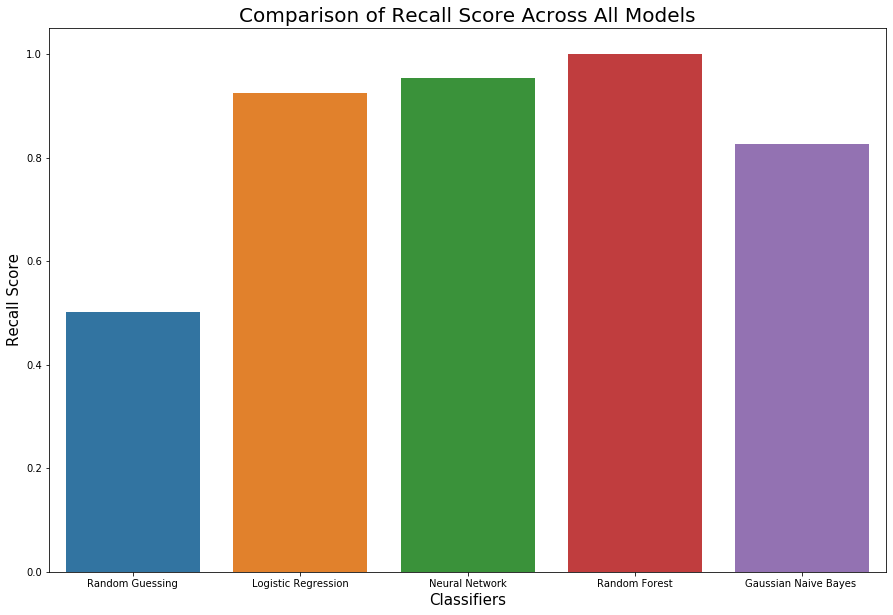

In [27]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='Recall Score')
plt.title('Comparison of Recall Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("Recall Score", fontsize=15)
plt.show()

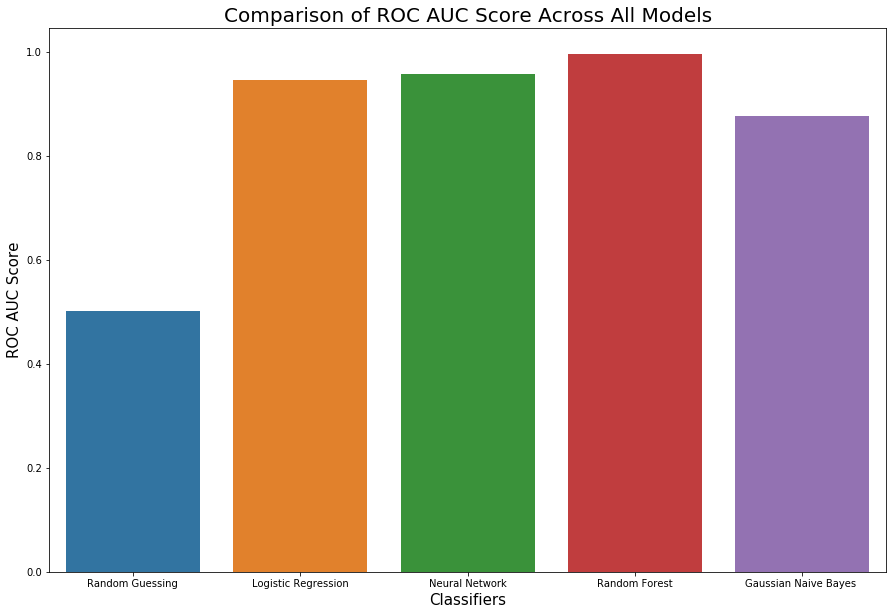

In [28]:
plt.figure(figsize=(15,10))
sns.barplot(data=resultdf, x='Classifiers', y='ROC AUC Score')
plt.title('Comparison of ROC AUC Score Across All Models', fontsize=20)
plt.xlabel("Classifiers", fontsize=15)
plt.ylabel("ROC AUC Score", fontsize=15)
plt.show()

#### Intermediary Workings of the Neural Network

In [29]:
X_transformed = th.tensor(X, dtype=th.float32)
representations = ffnn.get_intermediary(X_transformed.to(device))
representations = representations.cpu().detach().numpy()

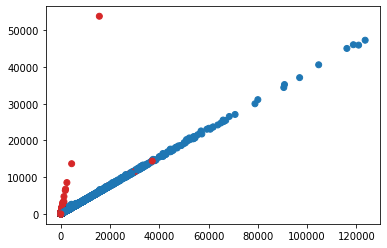

In [32]:
colors = np.array(['tab:red' if cl == 0 else 'tab:blue' for cl in y])
plt.scatter(representations[:,10], representations[:,46], c=colors)
plt.show()